<a href="https://colab.research.google.com/github/RohinSequeira/EVA6_Session9_resnets_and_higher_receptive_fields/blob/main/pytorch_custom_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Resnet Architecture

In [1]:
#!rm -rf pytorch_cifar10

In [2]:
!pip install torch
!pip install torchsummary

In [3]:
import torch
import torch.optim as optim

from torchsummary import summary
from torch.optim.lr_scheduler import StepLR, OneCycleLR, ReduceLROnPlateau

import os
import numpy as np

In [4]:
%%capture
!git clone https://github.com/RohinSequeira/pytorch_cifar10.git
!pip install albumentations==1.0.0

In [5]:
from pytorch_cifar10 import main as main
from pytorch_cifar10.model import custom_resnet as models
from pytorch_cifar10.utils import utils as utils
from pytorch_cifar10.utils.gradcam import generate_gradcam, plot_gradcam_images
from pytorch_cifar10.utils.CLR import CLR
from pytorch_cifar10.utils.OneCycle import OneCycle

## Data Loader & Albumentations

In [6]:
norm_mean,norm_std = utils.cifar10_mean_std()
train_transform, test_transform = utils.get_transforms_custom_resnet(norm_mean,norm_std)

# Extract and transform the data
train_set,test_set = utils.get_datasets(train_transform,test_transform)

# Targets -> ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = train_set.classes

# Dataloader Arguments & Test/Train Dataloaders - Load part of ETL
train_loader,test_loader = utils.get_dataloaders(train_set,test_set)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
(0.492, 0.483, 0.447) (0.247, 0.243, 0.262)
Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying 10 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


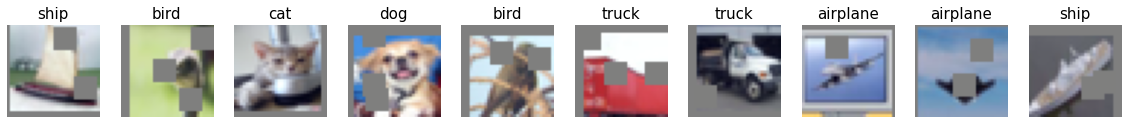

In [7]:
# Explore sample images
utils.show_sample_images(train_loader, classes, .5, .25, num_of_images = 10)

## Model Summary

In [13]:
# Model summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = models.ResNet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

## Training & Testing the Model

In [9]:
!pip install torch-lr-finder

In [14]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.002)
criterion = torch.nn.CrossEntropyLoss()

In [15]:
from pytorch_cifar10.utils import lr_finder


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.50E-02


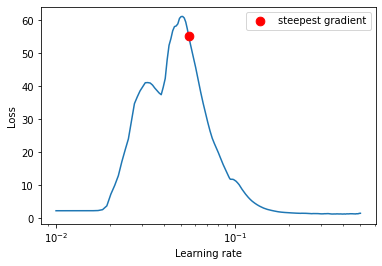

In [16]:
epochs=24
max_lr = lr_finder.find_lr(model, train_loader, test_loader, epochs, optimizer, criterion, device)

In [17]:
print(max_lr)

0.05501043841336117


In [18]:
EPOCH = 24
MAX_EPOCH=5
batch_size = 512
l1_factor = 0
l2_factor = 0.0001
lr_value = 0.001
mt_val = 0.9

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

utils.seed_everything(1)

model = models.ResNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.002)
scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader), epochs=EPOCH, pct_start=(MAX_EPOCH/EPOCH), div_factor=8)

print("------------------------------------------")
train_loss, test_loss, train_acc, test_acc = main.main(EPOCH, model, device, train_loader, test_loader, optimizer, scheduler, l1_factor)

------------------------------------------

Epoch 1 : 
Train set: Average loss: 1.3702, Accuracy: 32.88

Test set: Average loss: 0.003, Accuracy: 45.80

Epoch 2 : 
Train set: Average loss: 1.2244, Accuracy: 52.07

Test set: Average loss: 0.002, Accuracy: 60.82

Epoch 3 : 
Train set: Average loss: 1.0451, Accuracy: 61.94

Test set: Average loss: 0.002, Accuracy: 69.26

Epoch 4 : 
Train set: Average loss: 0.8514, Accuracy: 70.11

Test set: Average loss: 0.002, Accuracy: 72.19

Epoch 5 : 
Train set: Average loss: 0.6583, Accuracy: 75.31

Test set: Average loss: 0.002, Accuracy: 67.19

Epoch 6 : 
Train set: Average loss: 0.4510, Accuracy: 78.86

Test set: Average loss: 0.002, Accuracy: 72.43

Epoch 7 : 
Train set: Average loss: 0.4529, Accuracy: 81.01

Test set: Average loss: 0.001, Accuracy: 78.88

Epoch 8 : 
Train set: Average loss: 0.5118, Accuracy: 83.11

Test set: Average loss: 0.001, Accuracy: 78.03

Epoch 9 : 
Train set: Average loss: 0.4669, Accuracy: 84.90

Test set: Average loss:

## Accuracy and Loss Plots

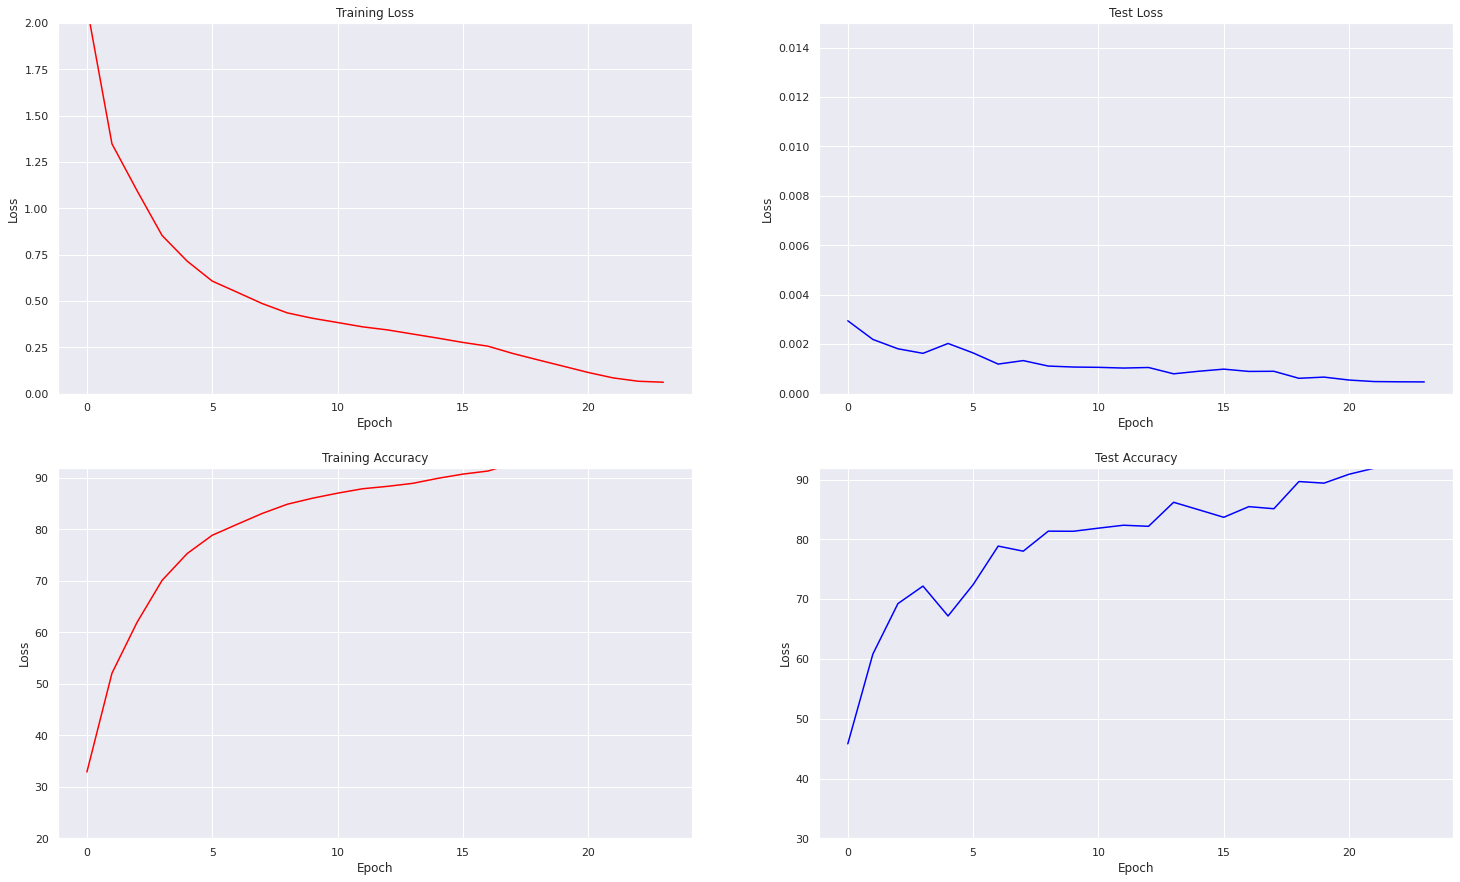

In [19]:
utils.valid_accuracy_loss_plots(train_loss, train_acc, test_loss, test_acc)

## Misclassified images

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

Total wrong predictions are 791


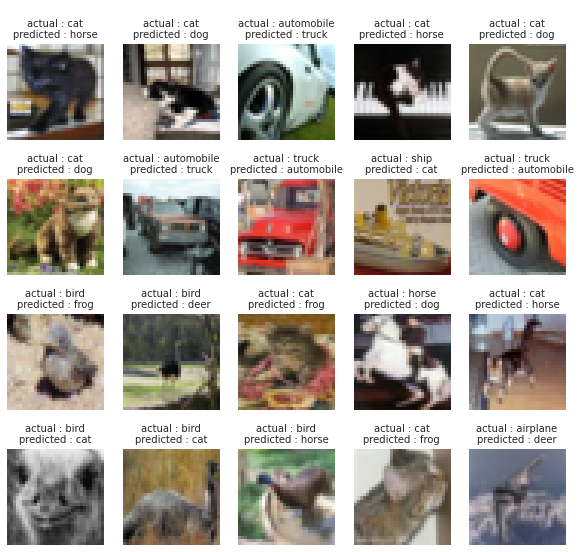

In [21]:
misclassified_images = utils.wrong_predictions(model,test_loader, norm_mean, norm_std, classes, device)